# I. Import libraries and prepare data

In [2]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

Downloading...
From (original): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
From (redirected): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM&confirm=t&uuid=e792601f-e822-4db4-a910-eb1b8f15941d
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 54.3MB/s]


In [ ]:
# If the dataset already available, skip the above line and run this line
!unzip -q icdar2003.zip

replace SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 1. Import libraries

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

In [ ]:
!pip install timm

In [ ]:
# Import libraries
import os
import shutil
import xml.etree.ElementTree as ET
import yaml
import json

import numpy as np
import pandas as pd

import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models , transforms
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split

## 2. Prepare data

### 2.1 Extract Data from XML and Store in YOLOv8 format

In [ ]:
def extract_data_from_xml(root_dir):
  """
  Extract data from the file words.xml in the IC03 dataset

  This function is used to extract information from file .xml, including:
  image paths, image sizes, image labels and bounding boxes

  Parameters:
    root_dir (str): the path to the root directory of the dataset

  Returns:
    tuple: contains 4 lists, they are: mage paths, image sizes, image labels and bounding boxes
  """

    # Create path to the file words.xml
  xml_path = os.path.join(root_dir, 'words.xml')
  #Parse xml file
  tree = ET.parse(xml_path)
  # Read the root tag of the xml file
  root = tree.getroot()

  # Initialize empty list to store data
  img_paths = []
  img_sizes = []
  img_labels = []
  bboxes = []

  # Loop through each image tag <image>
  for img in root:
      # Initialize empty list to store bounding boxes and the label of image
      bbs_of_img = []
      labels_of_img = []

      # Loop through each boundingbox tag
      for bbs in img.findall('taggedRectangles'):
          for bb in bbs:
              # Skip labels that are not in the alphabet or not number
              if not bb[0].text.isalnum():
                  continue

              # Skip labels with unicode characters
              if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                  continue

              # Append bbox information to list bbs_of_img
              # Format bbox: (xmin, ymin, bbox_width, bbox_height)
              bbs_of_img.append(
                  [
                      float(bb.attrib['x']),
                      float(bb.attrib['y']),
                      float(bb.attrib['width']),
                      float(bb.attrib['height'])
                  ]
              )
              # Append label to list labels_of_img (converted to lowercase)
              labels_of_img.append(bb[0].text.lower())

      # Append path of the current image to list img_paths
      img_path = os.path.join(root_dir, img[0].text)
      img_paths.append(img_path)
      # Append image size to list img_sizes
      img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
      # Append list of bounding boxes to list bboxes
      bboxes.append(bbs_of_img)
      # Append labels list to list img_labels
      img_labels.append(labels_of_img)

  return img_paths, img_sizes, img_labels, bboxes

In [ ]:
dataset_dir = '/content/SceneTrialTrain'
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(dataset_dir)

In [ ]:
print(f"Total images: {len(image_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bounding_boxes])}")

### 2.2 Convert to YOLOv8 format

In [ ]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    """
    Thực hiện normalize bounding box

    Parameters:
        image_paths (list): Danh sách chứa các path ảnh.
        image_sizes (list): Danh sách chứa độ phân giải ảnh.
        bounding_boxes (list): Danh sách chứa danh sách bounding box.

    Returns:
        yolov8_data (list): Danh sách gồm (image_path, image_size, bboxes)
    """
    # Khai báo list rỗng để chứa kết quả
    yolov8_data = []

    # Duyệt qua từng bộ path, resolution và bboxes ảnh.
    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        # Khai báo list rỗng để chứa label (format mới)
        yolov8_labels = []

        # Duyệt qua từng bbox
        for bbox in bboxes:
            x, y, w, h = bbox

            # Thực hiện normalize bbox
            # Format bbox hiện tại: (x_min, y_min, width, height)
            # Format bbox của yolo: (x_center, y_center, width, height)
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Mã class, mặc định = 0 vì chỉ có 1 class 'text'
            class_id = 0

            # Đổi format label
            # Format: "class_id x_center y_center width height"
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [ ]:
# Định nghĩa class
class_labels = ['text']

# Thực hiện lời gọi hàm
yolov8_data = convert_to_yolov8_format(
    image_paths,
    image_sizes,
    bounding_boxes
)

In [ ]:
yolov8_data

### 2.3. Train, val, test split

In [ ]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolov8_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

### 2.4. Save data

In [ ]:
def save_data(data, src_img_dir, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu theo format YOLO

    Parameters:
        data (list): Danh sách chứa thông tin label ảnh.
        src_img_dir (str): Path đến thư mục dữ liệu gốc.
        save_dir (str): Path đến thư mục dữ liệu mới.
    """
    # Tạo thư mục dữ liệu mới nếu chưa có
    os.makedirs(save_dir, exist_ok=True)

    # Tạo thư mục 'images' và 'labels'
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    # Duyệt qua từng bộ path, bbox, label ảnh
    for image_path, yolov8_labels in data:
        # Copy ảnh từ thư mục gốc sang thư mục 'images'
        shutil.copy(
            os.path.join(src_img_dir, image_path),
            os.path.join(save_dir, 'images')
        )

        # Ghi nội dung label vào file image_name.txt ở thư mục 'labels'
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")

In [ ]:
# Thực hiện lời gọi hàm cho 3 set train, val, test
save_yolo_data_dir = 'datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data,
    dataset_dir,
    save_train_dir
)
save_data(
    test_data,
    dataset_dir,
    save_val_dir
)
save_data(
    val_data,
    dataset_dir,
    save_test_dir
)

### 2.5. Create yaml file

In [ ]:
data_yaml = {
    'path': 'yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

# II. Text Detection

## 1. YOLOv8 Training

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')

# Train the model
epochs = 400
imgsz = 1024
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    imgsz=imgsz,
    project='models',
    name='yolov8/detect/train'
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 267MB/s]

Transferred 355/355 items from pretrained weights


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=datasets/yolo_data/data.yml, epochs=400, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 41.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 160MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1036.33it/s]


train: New cache created: /content/datasets/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 566.00it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


Plotting labels to models/yolov8/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to models/yolov8/detect/train
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      9.88G      2.029      6.054      1.817         52       1024: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]

                   all         43        200      0.419       0.49      0.397      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      9.88G      1.114      1.747       1.16         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.747      0.735      0.779      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      9.98G      1.111      1.469      1.182         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         43        200      0.639       0.67      0.628       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      9.95G      1.127       1.36       1.17         41       1024: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.418      0.615      0.503      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      9.83G      1.197      1.335      1.201         67       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.407       0.51      0.445      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400        10G      1.221       1.19      1.227         46       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.536      0.664      0.564      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      9.79G      1.216      1.139      1.211         26       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200       0.44      0.483      0.362      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      9.97G      1.215      1.169      1.237         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.412       0.58      0.386      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      9.73G      1.197      1.167      1.209         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.335      0.463      0.366      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400        10G      1.173        1.1      1.207         77       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.482      0.585      0.467      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      9.98G      1.206      1.057      1.216         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.593      0.752       0.66      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      9.98G      1.155      1.053      1.218        108       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.598       0.65      0.636      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      9.96G      1.135      1.018      1.204         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         43        200      0.724      0.641       0.68      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      9.76G      1.118     0.9858      1.181         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.749      0.725      0.766      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400        10G      1.093     0.9859       1.16         62       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200        0.7      0.735      0.699      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400        10G      1.093      1.004       1.14         74       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.677      0.625      0.638      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      9.76G      1.166     0.9934      1.184         56       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.686       0.64      0.668      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      9.99G      1.087      0.999      1.148         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.632      0.635      0.614      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400        10G        1.1      0.962       1.16         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.726      0.797      0.783       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400       9.8G      1.151     0.9562      1.146         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200      0.734      0.805      0.774      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      9.77G      1.063     0.9225      1.164         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.723      0.795       0.77      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      9.96G      1.051     0.9047      1.127         92       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.798      0.808      0.806      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      9.63G      1.108     0.9551      1.138         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.702       0.81       0.76       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400        10G      1.105     0.9979      1.158         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200       0.79      0.835      0.842      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      9.97G      1.043     0.9248       1.12         50       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.794      0.765      0.822      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400        10G      1.003     0.8538        1.1         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.811      0.845      0.827      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      10.4G      1.035     0.8411      1.131         52       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.851      0.856      0.847      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      10.4G      1.052     0.8888       1.14         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.834      0.829       0.85      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      9.89G     0.9865     0.8555      1.101         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.787       0.85      0.813      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      10.3G       1.04      0.881      1.132         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         43        200      0.845      0.815      0.856      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      10.4G      0.981     0.8285       1.09         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         43        200      0.782      0.791      0.794       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      10.4G          1     0.7904      1.097         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.798      0.815      0.869      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400        10G     0.9555     0.8248      1.086         47       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.848      0.839      0.873      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      9.96G     0.9768     0.7634      1.087         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.868       0.86      0.877      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      9.91G     0.9669     0.7746      1.061         48       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.873      0.835      0.855      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      9.75G     0.9845     0.8023       1.08         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.868      0.854      0.864      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      9.88G       0.91     0.7147      1.037         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         43        200      0.817       0.86      0.836      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400        10G     0.9774     0.7945      1.074         77       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.851      0.875      0.877      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      9.98G     0.9634     0.7786      1.049         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         43        200      0.786       0.87      0.842      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      10.3G     0.9365     0.7606      1.065         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.852      0.832       0.85        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      10.3G     0.8952     0.7413      1.072         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.853       0.82      0.831       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      9.96G     0.9353     0.7345      1.049         75       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.793       0.88      0.868      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      10.4G     0.9414     0.7558      1.073         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200      0.826      0.765      0.817      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      10.1G      0.999     0.7755      1.064         60       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.782      0.845      0.825      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400       9.9G     0.9145      0.724       1.04         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.782      0.865      0.844      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      9.63G     0.8885     0.6903      1.055         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.872      0.884      0.898      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400       9.9G     0.9008     0.7014       1.04         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.859      0.851      0.885      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      9.98G     0.9376     0.7074      1.075         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.888        0.8      0.871      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      9.99G     0.9096     0.7195      1.045         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.864      0.887      0.896      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      9.75G     0.9268     0.6933      1.066         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.844      0.915      0.889      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      9.97G      0.912     0.7024      1.052         58       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.873       0.88      0.905      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      10.2G     0.9062     0.6979      1.024         68       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.862      0.885      0.882      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      9.76G     0.8348     0.6604      1.015         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.842      0.855      0.864      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400        10G     0.8844     0.6729       1.06         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.829      0.835      0.855      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400        10G     0.8893     0.6871      1.045         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.796      0.845      0.833      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400        10G     0.8702     0.6901      1.021         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.762       0.89      0.833       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      9.88G     0.8744     0.6701      1.037         60       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.847      0.855      0.867      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400        10G     0.8585     0.6689      1.028         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.839      0.855       0.89      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400        10G     0.8509     0.6546      1.023         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.837      0.874      0.887      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400        10G     0.8342     0.6438      1.001         51       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200       0.83       0.86      0.884      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      9.98G     0.8414     0.6293      1.026         45       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.805      0.887      0.877      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      9.62G     0.8281     0.6372      1.012         61       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.834      0.895      0.884      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400        10G     0.7942     0.6075      0.972         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.847      0.915      0.904      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      9.96G     0.8631     0.6628      1.047         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         43        200      0.873      0.865      0.902      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      9.75G     0.8751     0.6392      1.011         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43        200      0.908      0.845      0.919      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      9.97G     0.8778     0.6486      1.015         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.874      0.869      0.909      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400        10G     0.8473     0.6195      1.005         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.884      0.873        0.9      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      9.83G     0.8271     0.6206      1.003         31       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         43        200      0.895      0.895      0.913        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      9.78G     0.8237     0.5989     0.9958         69       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.871      0.805      0.873      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      9.98G     0.8285     0.6104      1.003         75       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.841      0.825      0.894      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400        10G     0.8201     0.5988      1.003         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.843      0.885      0.897      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400        10G     0.8109     0.5821      1.003         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.879      0.795      0.881      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400       9.9G     0.8127     0.5941      1.007         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200       0.82        0.9      0.906      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      9.97G     0.7924     0.5645     0.9985         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200        0.9      0.856      0.902      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400        10G     0.7801     0.5797     0.9879         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.874       0.82      0.868      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      9.97G     0.8117      0.587     0.9928        102       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         43        200      0.869       0.83      0.874      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      9.81G     0.8036      0.601     0.9896         57       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.885      0.846      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      9.78G     0.8119     0.6081      1.005         47       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.881      0.835        0.9      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400        10G     0.7972     0.5975     0.9904         46       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200       0.87      0.875      0.902      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      10.3G      0.819     0.6421      1.006         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.858       0.91      0.897      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      10.4G      0.777     0.6123     0.9851         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.859       0.92      0.909      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      10.4G     0.7718       0.59     0.9985         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         43        200      0.832      0.891      0.888      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      9.64G     0.8159     0.6241      1.013         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.864      0.891      0.894      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      9.64G     0.8055     0.5903      1.015         71       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.852      0.895      0.907      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      9.76G     0.8083     0.5936      1.002         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.834      0.895      0.897       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      9.91G     0.8017     0.5721     0.9974         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.895       0.81      0.893      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      9.78G      0.801     0.5717     0.9881         70       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.877      0.858      0.898      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      9.98G     0.8341     0.6134      1.017         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.804       0.92      0.904      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      9.93G     0.7857     0.5747      0.976         72       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.883       0.87      0.887      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      9.97G     0.7931     0.5731       0.99         57       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.881      0.812      0.873      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400      9.98G     0.7936     0.5958     0.9833        106       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.881      0.848      0.891       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400        10G     0.7685     0.5629     0.9766        107       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         43        200       0.88      0.919      0.898      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400      9.95G      0.772     0.5449     0.9601         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         43        200       0.89      0.885      0.897      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400        10G     0.7557     0.5363     0.9712         27       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.854       0.87      0.896      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400        10G     0.7425     0.5303     0.9589         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         43        200      0.883       0.88      0.906      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400        10G     0.7767     0.5616     0.9786         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.874      0.867      0.881      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400       9.9G     0.7602     0.5621      0.971         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.901      0.867      0.909      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      9.89G     0.7584     0.5379     0.9613         57       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200      0.834      0.935      0.924      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400        10G     0.7541     0.5446     0.9799         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200       0.89      0.835      0.895      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      9.98G     0.7557     0.5488     0.9721         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.897        0.9       0.91      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      9.88G     0.7439      0.553     0.9733         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         43        200      0.899       0.89      0.904      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      9.93G     0.7307     0.5412     0.9749         32       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.884      0.895      0.918      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400        10G      0.735     0.5346     0.9571         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200      0.897      0.826      0.901      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      9.85G     0.7177     0.5265     0.9599         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.901       0.87      0.894      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      9.59G     0.7662     0.5326     0.9588         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.903      0.836      0.915      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400        10G     0.7413     0.5359     0.9705         82       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.901      0.862      0.923      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400        10G      0.724     0.5196     0.9602         46       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200       0.91      0.875      0.912      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400        10G     0.7362     0.5151     0.9529         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         43        200      0.918       0.87      0.909      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      9.97G     0.7098     0.5241     0.9618         93       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         43        200      0.878      0.866        0.9      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400      9.97G     0.7236     0.5134     0.9615         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.904       0.85      0.899      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      9.85G     0.7367     0.5223     0.9705         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         43        200      0.894       0.88      0.896      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400        10G     0.7173     0.5068     0.9465         91       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.899      0.865      0.888      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      9.79G     0.7198     0.4974     0.9457         69       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.858      0.885      0.897      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400        10G     0.7409     0.5086     0.9722         34       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.876      0.887      0.901       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      9.98G     0.6906     0.5083     0.9451         44       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.865      0.885      0.901      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400        10G     0.7304     0.4931     0.9452         82       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         43        200      0.899      0.846        0.9      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      9.99G     0.7108     0.4823     0.9488         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         43        200      0.858      0.906      0.902      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      10.4G     0.6906      0.488     0.9434         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.881      0.885      0.912      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      10.4G     0.7244     0.5103     0.9662         89       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.872      0.885      0.913      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      9.99G     0.7185     0.5235     0.9767         51       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         43        200      0.884       0.87      0.916       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400        10G     0.7126     0.4906     0.9387         79       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.897      0.872      0.911      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400        10G     0.7061     0.4893     0.9689         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.905      0.857      0.912      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400        10G     0.6975     0.4811     0.9556         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.908      0.844      0.914      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      9.64G     0.6977     0.5005     0.9454         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.914      0.845      0.908       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      9.78G     0.6639     0.4717     0.9353         46       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.905      0.854      0.913      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      9.96G     0.6809     0.4951     0.9598         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200       0.89       0.89       0.92        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      9.79G     0.6771     0.4883     0.9412         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200       0.87      0.903      0.907      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      9.92G     0.7356     0.5207     0.9584         34       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.859      0.913      0.924      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      9.98G     0.7207     0.5141     0.9565         86       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.899      0.887      0.905        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      9.96G     0.7019     0.4916     0.9459         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.892      0.866       0.92      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      9.98G     0.6936     0.5085     0.9406         44       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.897       0.84       0.92      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      9.97G     0.6908      0.507     0.9603         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200      0.879      0.895      0.925      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      9.65G     0.6898     0.5052     0.9534         26       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         43        200      0.877        0.9      0.928      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      9.97G     0.6768     0.4716     0.9447         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         43        200      0.865      0.905      0.911      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      9.65G     0.6987     0.4909     0.9358         80       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.919      0.846      0.898      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400      9.83G     0.6886     0.4677     0.9387         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.893      0.874      0.898      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400        10G     0.7003     0.4723     0.9544         83       1024: 100%|██████████| 13/13 [00:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.907       0.88      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      9.76G     0.6677      0.474     0.9437         74       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.888       0.88      0.912      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400        10G     0.6578     0.4832     0.9487         43       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.929      0.857      0.917      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      9.79G     0.7009     0.4853     0.9489         88       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.895        0.9      0.909      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400      9.88G     0.6683     0.4725     0.9342         95       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.869      0.893      0.919      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400      9.91G     0.6574      0.475     0.9342         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.889      0.855      0.908      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      9.96G     0.6919     0.5066     0.9421         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.862      0.878      0.902      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400      9.81G     0.6633     0.4693     0.9182         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.882      0.859      0.893      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      9.78G     0.6555     0.4608     0.9269         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.895      0.885      0.912      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400      9.96G     0.6652     0.4785     0.9414         45       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.909       0.87      0.917      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      9.97G     0.6422     0.4468     0.9499         44       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.879      0.873      0.903      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400      9.78G     0.7127     0.4975     0.9422         97       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.862      0.874      0.882      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400      9.99G     0.6581     0.4572     0.9404         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.897      0.875      0.909       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      9.94G     0.6527      0.455     0.9478         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.867      0.935      0.917      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400        10G     0.6384     0.4526       0.92         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.879      0.925       0.92      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400      9.98G     0.6366     0.4504     0.9425         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.871       0.92      0.912      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400      9.88G     0.6427     0.4523     0.9391         58       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.889       0.88      0.918      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      9.63G     0.6508      0.456      0.929         55       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.896      0.909      0.925      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      9.79G     0.6275     0.4372      0.925         36       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.887      0.942      0.924      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400      9.98G      0.681     0.4596     0.9249        101       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         43        200      0.917      0.889      0.924       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400      9.98G     0.6406      0.447     0.9211         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.915      0.857      0.923      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400      9.75G     0.6428     0.4381      0.916         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.933      0.865      0.929      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400      9.81G     0.6356     0.4576     0.9309         76       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         43        200      0.908      0.845      0.925      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      10.2G     0.6381     0.4442     0.9254         51       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.899      0.855      0.926      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      9.88G     0.6351     0.4413       0.92         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.908      0.889      0.927      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400      9.98G     0.6443     0.4305     0.9308         76       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.924      0.849      0.913      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400      9.94G     0.6401     0.4491     0.9468         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.903       0.84      0.915       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400       9.8G     0.6242     0.4435     0.9255         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.882      0.895      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      9.96G     0.6107     0.4256     0.9211         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.865       0.89      0.913      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400      9.97G     0.6323     0.4467      0.947         90       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.911      0.868      0.916      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      9.85G     0.6377     0.4333     0.9298         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.889      0.885      0.905        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400      9.97G      0.643     0.4339     0.9402         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.907      0.881      0.923      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      9.75G     0.6206     0.4298     0.9207         51       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.918      0.892      0.924      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400        10G      0.627     0.4414     0.9239         75       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.922       0.88      0.923      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      9.92G     0.6162     0.4375     0.9287         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200       0.91      0.885      0.927      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400      9.97G     0.6258     0.4387     0.9156         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.907      0.878      0.918      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400      9.75G     0.6228     0.4449      0.941         73       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         43        200      0.941       0.87      0.933      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      9.81G     0.6417     0.4301     0.9221         78       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200      0.893      0.915      0.933      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400      9.97G     0.6131     0.4416     0.9386         22       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200       0.88      0.918       0.93       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400        10G     0.6316       0.45     0.9377         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.925      0.895      0.931      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400      9.89G     0.6226     0.4349     0.9287         28       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.913      0.895      0.931      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      10.3G     0.6275     0.4361     0.9276         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.904      0.898       0.92      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400        10G     0.6116     0.4301     0.9203         76       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.871      0.914      0.904      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400      9.94G     0.5851     0.4323     0.9178         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         43        200      0.925      0.863       0.91      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400       9.6G     0.6013     0.4262     0.9171         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         43        200      0.903      0.884        0.9      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400      9.98G     0.6235     0.4308     0.9334         28       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.922       0.89       0.92      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400       9.8G     0.5976     0.4193     0.9066         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.905       0.88      0.922      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400      9.96G     0.6349     0.4396     0.9228         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200      0.872       0.89      0.907      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400      10.4G     0.6343     0.4178     0.9194         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200       0.91       0.88      0.915      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400      9.98G     0.6136     0.4272     0.9255         38       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.914      0.854      0.908      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400      10.4G     0.6195     0.4248     0.9339         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.881       0.89      0.891      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400      9.97G     0.6032     0.4169     0.9061         62       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.872       0.88      0.889      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      9.75G     0.5976     0.4205      0.918         33       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         43        200      0.851      0.885      0.893      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      10.4G     0.5819     0.4066     0.9181         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.898      0.877      0.904      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400      9.97G     0.5657     0.3988     0.9009         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.886       0.91      0.921      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400      10.3G     0.5918     0.4163     0.9105         60       1024: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.911       0.88      0.923       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400      9.98G     0.6062     0.4067     0.9097         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.896      0.895      0.928      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      10.4G     0.5987     0.4122     0.9195         60       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.851      0.915      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400      9.73G     0.5908     0.4074     0.9034         76       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.883      0.905      0.909      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400      9.99G     0.5792      0.393     0.8987         96       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.875       0.93      0.915      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400      9.97G     0.5535     0.3917      0.901         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.875       0.92      0.915      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400      9.97G     0.5864      0.408      0.906         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43        200      0.892        0.9      0.915      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      9.97G     0.5435     0.3782     0.9016         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.909       0.87      0.914      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400        10G     0.5718     0.3929     0.9096         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.925       0.86       0.91      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400      9.97G     0.5886     0.4023     0.9168         49       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.901      0.908      0.934      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      10.4G      0.578     0.4007     0.9123        152       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.884      0.914       0.93       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400      9.94G     0.5396     0.3756     0.8972         63       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200       0.91      0.875      0.923      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      10.3G     0.5605     0.3871     0.8961         58       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.891      0.899      0.926      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400        10G     0.5527     0.3868     0.9051         46       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.894       0.89       0.92      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400      9.81G     0.5577      0.382     0.8877         34       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200        0.9       0.89      0.924      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400       9.8G     0.5438     0.3772     0.8856         83       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         43        200      0.911      0.872      0.923      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      9.76G     0.5904     0.3898     0.9192         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.915      0.857      0.925      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400        10G     0.5493     0.3822      0.898         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.881        0.9      0.924      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400      9.96G     0.5627     0.3832     0.8961         84       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.922      0.855      0.932      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      9.92G     0.5836     0.3896     0.9093         34       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.881      0.865      0.923      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      10.4G     0.5411     0.3763     0.9005         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         43        200      0.903      0.895      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400      9.77G     0.5587     0.3909     0.8963         86       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.894      0.882      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400        10G     0.5561     0.3731     0.9035         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.911      0.867      0.931      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400       9.9G     0.5818     0.3959     0.9229         45       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.837      0.922      0.923      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400      9.98G     0.5819     0.4034     0.9107         97       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200      0.862      0.909      0.924      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      9.88G     0.5599     0.3821     0.8816         86       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.888      0.915      0.925      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      9.77G     0.5646     0.3765     0.8876         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         43        200      0.895       0.91      0.922      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400        10G     0.5571     0.3808     0.8878         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.882      0.925      0.919      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400      10.2G     0.5544     0.3867     0.9024         77       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.849      0.931      0.924      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      9.76G     0.5408     0.3832     0.8859         27       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.891      0.899      0.926      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400      10.4G     0.5237     0.3699     0.8967         77       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.905       0.91       0.93      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400        10G     0.5409      0.376     0.8961        100       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.909       0.89       0.94      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      9.98G     0.5578      0.384     0.8902         96       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.912      0.878      0.934      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400        10G     0.5073     0.3622     0.8897         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.905       0.88      0.921      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400        10G      0.555     0.3817     0.8952         40       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200       0.83      0.928      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400      9.84G     0.5372     0.3654       0.87         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43        200      0.883       0.91      0.926      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400      9.99G     0.5306     0.3635     0.8928         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.891       0.94      0.933      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      9.96G     0.5446     0.3738     0.9063         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         43        200      0.863       0.96      0.934      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400      9.97G     0.5307     0.3649     0.8937         95       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.868      0.895       0.93      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400      9.98G     0.5367     0.3744     0.8915         62       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.832      0.913      0.928       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400       9.9G     0.5221     0.3704     0.8963         69       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.891      0.865      0.914      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400      9.93G     0.5336     0.3675     0.8918         66       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.872      0.889      0.914      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400      9.64G     0.4951      0.357     0.8822         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.884      0.875      0.909      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400        10G     0.5423     0.3653     0.8978         75       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.874      0.875       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400      9.64G     0.5554     0.3947     0.8946         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         43        200       0.94       0.83      0.928      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400      9.94G     0.5164     0.3598      0.889         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.908       0.86      0.927      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400        10G     0.5387     0.3662     0.8999         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200       0.87      0.874      0.924      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400        10G     0.5538     0.3724     0.8987         43       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.864      0.893      0.917      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/400      10.4G     0.5233      0.376     0.8841         46       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.897      0.872      0.921      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/400      9.97G     0.5246     0.3557     0.8787         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.847      0.925      0.923      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/400      9.97G     0.5138     0.3584     0.9034         45       1024: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.872      0.895      0.927      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/400        10G     0.5196     0.3555     0.8921         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.888      0.908      0.929      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/400        10G     0.5246     0.3631     0.8902         32       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43        200       0.88      0.915      0.926      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/400       9.9G     0.5371      0.366     0.8958         76       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.896      0.905      0.916      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/400      10.2G     0.5227     0.3719     0.8961         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.916       0.89      0.927      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/400        10G     0.5432     0.3658     0.9044         31       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.906       0.87       0.92      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/400        10G      0.516     0.3536     0.8763         81       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200       0.89      0.885      0.927      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/400      9.95G     0.5081     0.3488     0.8856         40       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.917       0.88      0.933      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/400      9.98G     0.5058     0.3567     0.8914         43       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.908      0.895      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/400      10.4G     0.5057     0.3492     0.8959         74       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.899       0.89      0.931      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/400      9.82G     0.5278     0.3676     0.8862         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.911      0.865      0.927      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/400        10G     0.4993     0.3394     0.8736         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.908        0.9      0.928      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/400      9.97G     0.4889     0.3452     0.8808         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.894      0.905       0.92      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/400        10G     0.5178     0.3625     0.8865         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.891        0.9      0.922      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/400      10.4G     0.5248     0.3677     0.8922         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.915        0.9      0.918      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/400      9.95G      0.523     0.3612     0.8854         61       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.884      0.913      0.911      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/400      9.98G     0.5016     0.3476     0.8828         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.884      0.915      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/400      9.62G     0.5101     0.3538     0.8787         78       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.893      0.913       0.93      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/400      10.2G     0.4903     0.3491     0.8688         51       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.899        0.9      0.933      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/400      9.98G     0.4973     0.3369     0.8692         87       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.916      0.876      0.924      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/400      10.4G     0.4789     0.3426     0.8715         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         43        200      0.878      0.915       0.92      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/400      9.78G     0.5014     0.3525     0.8825         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43        200      0.918      0.885      0.927      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/400       9.9G     0.4959     0.3575     0.8861         99       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.887      0.943      0.932      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/400      9.79G     0.5002     0.3478     0.8841         86       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.891       0.95      0.929      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/400      10.1G     0.5062     0.3535      0.883         91       1024: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.929      0.921      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/400      9.97G     0.4765     0.3293     0.8874         54       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.922      0.905      0.924      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/400      10.4G     0.4755     0.3389     0.8751         80       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.931      0.878      0.921       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/400      9.98G     0.5042     0.3499     0.8865         61       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.901      0.911       0.92      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/400      9.75G      0.491     0.3394     0.8767         99       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.903      0.905      0.919       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/400      9.93G     0.4739      0.332     0.8749         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         43        200      0.897      0.917      0.921      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/400      10.3G      0.495     0.3394     0.8858         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200       0.91      0.915      0.917      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/400      9.77G     0.5093     0.3477     0.8944         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.905      0.901      0.917      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/400      9.68G     0.4926     0.3474     0.8763         32       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.915        0.9      0.923      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/400      9.97G     0.4741     0.3252      0.877         50       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.868      0.921      0.928      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/400        10G     0.4825     0.3301     0.8669         71       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.896      0.903      0.926      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/400      9.98G     0.4645     0.3267     0.8664         55       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.901       0.91      0.929      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/400      9.96G      0.477     0.3336     0.8803         46       1024: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.907        0.9      0.931      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/400      9.99G     0.4812     0.3333     0.8738         52       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.896       0.89      0.924      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/400      9.93G     0.4458     0.3124     0.8707         77       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.939      0.875      0.921      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/400        10G      0.495     0.3522     0.8878         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         43        200      0.922      0.885      0.927      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/400        10G      0.469     0.3229     0.8587         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         43        200      0.922      0.887      0.927      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/400      9.83G     0.4665     0.3222     0.8733         24       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.921       0.88      0.927      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/400        10G     0.4632     0.3194     0.8721         86       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.904      0.895      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/400      10.3G     0.4722     0.3359     0.8687         65       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.918      0.895      0.929      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/400        10G     0.4609      0.318     0.8648         70       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.888       0.91       0.93      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/400      10.1G     0.4558     0.3164     0.8636         64       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.926        0.9      0.936      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/400       9.9G     0.4535     0.3168     0.8725         51       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.893      0.916      0.937      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/400      9.97G     0.4833     0.3281     0.8734         61       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         43        200      0.913       0.91      0.941      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/400      9.83G     0.4988     0.3411     0.8881         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.921      0.915       0.94      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/400      10.4G     0.4586     0.3292     0.8696         54       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200       0.91      0.913      0.935      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/400      10.4G     0.4628     0.3212     0.8741         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.918      0.896       0.93      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/400      9.77G     0.4545     0.3135     0.8699         84       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.893      0.915      0.926      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/400      9.76G     0.5069     0.3435     0.8813        115       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.906      0.915      0.924      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/400      9.79G     0.4519     0.3174     0.8635         67       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.898       0.92      0.932      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/400      10.4G     0.4625     0.3259      0.876         57       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.899      0.932       0.94      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/400      9.98G     0.4424     0.3085     0.8712         76       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.925        0.9       0.94      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/400      9.91G     0.4322     0.3079     0.8669         66       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200       0.91      0.915      0.943      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/400      9.78G     0.4532     0.3101     0.8565         62       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.918      0.901      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/400      9.97G     0.4385     0.2994     0.8521         88       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.873       0.92      0.919      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/400      9.95G      0.433     0.3016     0.8658         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         43        200      0.886        0.9      0.916      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/400      9.79G      0.434     0.3044     0.8635         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.882      0.897      0.919      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/400      9.98G      0.459     0.3122     0.8692         79       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.889      0.905      0.927      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/400      9.85G     0.4708      0.313     0.8769         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.871      0.912      0.931      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/400      9.94G     0.4604     0.3181      0.868         76       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         43        200      0.879      0.912      0.936      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/400      9.97G     0.4584     0.3099     0.8634        120       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.898      0.927      0.938      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/400        10G     0.4248     0.3126     0.8527         58       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         43        200      0.902      0.922      0.944      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/400        10G     0.4667     0.3191     0.8586         75       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200       0.91      0.925      0.948      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/400      9.77G     0.4601     0.3199     0.8603         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.934      0.923      0.948       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/400      9.82G     0.4469     0.3061       0.86         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         43        200       0.92       0.93      0.949      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/400      9.96G      0.433     0.3076     0.8604         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.938      0.901      0.947      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/400      9.96G     0.4325     0.3049     0.8607         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.938        0.9      0.942       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/400       9.8G     0.4589     0.3287     0.8752         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.926      0.905      0.941       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/400      9.97G     0.4408     0.3092     0.8707         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.906      0.915      0.941      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/400      9.92G      0.435     0.3026     0.8559         83       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.906      0.912       0.94      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/400      9.99G     0.4386     0.3036     0.8695         49       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.906      0.916      0.941      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/400      9.96G     0.4485     0.3093     0.8746         53       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.905      0.925      0.942      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/400      9.97G     0.4348     0.3081     0.8727         47       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.914       0.92      0.941      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/400      9.75G     0.4333     0.3038     0.8557         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.919      0.906      0.942      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/400      9.98G     0.4413     0.3087     0.8695         82       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200       0.92      0.915       0.94      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/400      9.78G     0.4397     0.3101     0.8525         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.918      0.925      0.943      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/400      9.75G     0.4207      0.308     0.8511         71       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.917       0.91      0.945      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/400      9.68G     0.4416     0.3065     0.8637         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.915       0.91      0.948      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/400      9.93G      0.415     0.2998     0.8717         28       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.909      0.915      0.949      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/400      9.69G     0.4292     0.2969      0.864         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.931      0.915      0.948      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/400      9.95G     0.4223     0.2906     0.8674         48       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.929      0.911      0.943      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/400      9.98G     0.4153     0.2968     0.8662         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.928      0.901      0.943      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/400        10G     0.3916     0.2955     0.8625         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.929      0.909      0.943      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/400      9.95G     0.4213     0.2977     0.8586         88       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.937       0.89      0.943      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/400      9.78G     0.4302     0.3058     0.8718         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.923        0.9      0.944      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/400      9.81G     0.4331     0.3119     0.8714         65       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200       0.91      0.913      0.943      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/400        10G     0.4211     0.3023     0.8692         38       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.896      0.915      0.941      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/400      9.99G      0.419     0.3029     0.8707         65       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         43        200      0.927      0.889      0.941      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/400      9.97G     0.4244     0.2911     0.8637         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200       0.94       0.89      0.943      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/400      9.79G     0.4078     0.2953      0.864         38       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.933      0.885      0.945      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/400      9.79G     0.4129     0.2863     0.8592         91       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.911      0.915      0.944      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/400      9.94G     0.3999     0.2864     0.8524        104       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.891      0.936      0.941      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/400      9.91G     0.4158     0.2979     0.8585         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         43        200      0.923      0.904      0.944      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/400      9.77G     0.4241     0.2963     0.8604         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200       0.91      0.925      0.947       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/400      9.97G     0.4134      0.293     0.8618         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         43        200      0.927       0.91      0.947      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/400      9.99G     0.3908     0.2833     0.8487         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.926        0.9      0.946      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/400      9.78G     0.4093        0.3     0.8645         40       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.882      0.933      0.945      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/400      9.79G     0.3814     0.2877     0.8615         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.922        0.9      0.947      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/400        10G     0.3923     0.2823     0.8512         70       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.909      0.895      0.946      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/400      9.99G     0.3874     0.2799     0.8558         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         43        200      0.893      0.925      0.948      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/400      9.97G     0.3879     0.2742     0.8532         99       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.918      0.905      0.948      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/400      9.78G     0.4159     0.2953     0.8514         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         43        200      0.938      0.903      0.952      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/400      9.72G     0.4226     0.3055     0.8683         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200       0.93      0.905      0.955      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/400      9.63G     0.4133     0.2921     0.8556         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.935      0.905      0.954      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/400       9.9G     0.3981     0.2801     0.8553         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.908      0.939      0.954      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/400      9.99G     0.4005     0.2852     0.8561         33       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.937      0.925      0.955      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/400      9.97G     0.3964     0.2873     0.8556         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.936      0.925      0.954      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/400        10G     0.3993     0.2869      0.859         95       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.938      0.909      0.952      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/400      9.96G     0.3993      0.292       0.87         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.915      0.915       0.95      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/400      9.98G     0.4107     0.2933     0.8612         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.902      0.935       0.95      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/400      9.97G     0.4134     0.2911     0.8602         54       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200        0.9      0.935       0.95      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/400       9.8G     0.3892     0.2826     0.8575         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.907      0.924      0.948       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/400      10.4G     0.3944     0.2837     0.8515         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.915      0.913      0.946       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/400      10.2G      0.408     0.2984     0.8588         27       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         43        200      0.911       0.92      0.948      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/400      10.2G     0.4149     0.2841     0.8642         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.902      0.935      0.951      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/400      9.73G     0.4038     0.2934     0.8575         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.905      0.935      0.951      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/400      10.4G     0.3948     0.2916     0.8577         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.907       0.93      0.951      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/400      10.4G     0.3824     0.2763      0.844         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200       0.91       0.94      0.949      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/400      10.4G     0.3822     0.2793     0.8439         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.915      0.921      0.947      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/400      9.95G     0.3875     0.2789     0.8551         32       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.911      0.924      0.946      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/400      9.98G     0.3834     0.2746     0.8483        142       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.907       0.93      0.945      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/400      9.98G       0.37     0.2689     0.8504         54       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43        200      0.918      0.925      0.946       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/400      10.4G     0.3759      0.277     0.8541         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         43        200      0.924      0.915      0.947      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/400      10.2G     0.3887     0.2798       0.85        106       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.938      0.903      0.949      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/400      10.4G     0.3734     0.2636     0.8533         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.916      0.929       0.95      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/400      9.97G     0.3905      0.278     0.8482         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.929       0.92       0.95      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/400      9.78G     0.3808     0.2837     0.8569         23       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.925      0.931      0.952      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/400      9.76G     0.3863     0.2769      0.856         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.934      0.923      0.953      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/400      9.79G     0.3879     0.2704     0.8538         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200      0.932      0.925      0.952      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/400      9.98G     0.3737     0.2731     0.8531         90       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         43        200      0.934      0.923      0.953      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/400      9.99G     0.3655     0.2608     0.8625         98       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200      0.933       0.93      0.957      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/400      10.4G     0.3693      0.267     0.8469        114       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.929      0.935      0.957      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/400      10.2G      0.397     0.2842     0.8501         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.934      0.924      0.956      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/400      10.4G     0.3767     0.2686     0.8569         31       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.939       0.92      0.956      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/400      10.4G     0.3787     0.2728     0.8531         64       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         43        200      0.931       0.92      0.956      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/400      9.95G     0.3642      0.262     0.8591         78       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.919       0.93      0.955      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/400        10G     0.3678     0.2614     0.8485         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.921      0.933      0.954      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/400      9.99G     0.3565     0.2659     0.8409         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.924      0.925      0.954      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/400      9.97G     0.3669     0.2613     0.8368         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         43        200      0.928      0.925      0.955       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/400      9.98G     0.3481     0.2517     0.8532         55       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         43        200      0.932      0.925      0.956      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/400      9.89G     0.3468      0.255     0.8452         88       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.933       0.92      0.956      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/400      9.91G     0.3775     0.2671     0.8514         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         43        200      0.925      0.924      0.955      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/400      9.79G     0.3805     0.2711     0.8516         46       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.921      0.925      0.955      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/400      9.89G     0.3453     0.2649     0.8436         66       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.924       0.93      0.955       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/400      9.85G     0.3605     0.2707     0.8485         53       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.921       0.93      0.955      0.759


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/400      9.98G     0.3492     0.2486     0.8204         36       1024: 100%|██████████| 13/13 [00:13<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.934      0.924      0.954      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/400      9.97G     0.3298     0.2455     0.8024         27       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.937       0.91      0.951      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/400      9.83G     0.3421     0.2474     0.8101         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.933       0.91      0.949      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/400      10.3G     0.3364     0.2508     0.8099         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.933      0.915      0.949      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/400      9.92G     0.3427     0.2463     0.8184         31       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200       0.92       0.92      0.949      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/400      9.76G     0.3434     0.2533     0.8136         18       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.925       0.92      0.949      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/400      9.95G      0.318     0.2385     0.8167         20       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.929      0.922      0.949      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/400      9.91G     0.3468     0.2551     0.8091         22       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.929      0.921      0.948      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/400      9.97G     0.3319     0.2473     0.8071         28       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200       0.92      0.923      0.946      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/400      9.85G     0.3115     0.2301     0.8108         49       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.916       0.93      0.945      0.747



400 epochs completed in 1.298 hours.
Optimizer stripped from models/yolov8/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from models/yolov8/detect/train/weights/best.pt, 22.6MB

Validating models/yolov8/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         43        200      0.934      0.924      0.957      0.766
Speed: 0.5ms preprocess, 10.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to models/yolov8/detect/train


## 8. Evaluation

In [ ]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='models',
    name='yolov8/detect/val'
)

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


                   all         43        200      0.934      0.923      0.956      0.765
Speed: 0.6ms preprocess, 54.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to models/yolov8/detect/val


## 9. Inference

In [20]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

In [ ]:
!ls /content/SceneTrialTrain/apanar_06.08.2002

{'name': 'text', 'class': 0, 'confidence': 0.95003, 'box': {'x1': 571.35773, 'y1': 923.86816, 'x2': 745.95135, 'y2': 992.62048}}


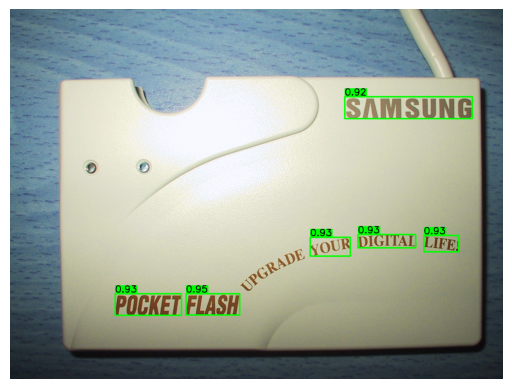

In [24]:
from ultralytics import YOLO

model_path = './best.pt'
img_path = '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG'
conf_thres=0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].tojson())
print(predictions[0])
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()

In [26]:
images_test_model = []
for img_path in os.listdir(path='/content/SceneTrialTrain/apanar_06.08.2002'):
  image_path = os.path.join('/content/SceneTrialTrain/apanar_06.08.2002', img_path)
  images_test_model.append (image_path)

images_test_model[:10]

['/content/SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1302.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1303.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1289.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1316.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/Img_1313.jpg',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1292.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1269.JPG',
 '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1285.JPG']

In [27]:
def inference (model_path, image_paths):
  conf_thres=0.75
  model = YOLO(model_path)

  # Run inference
  for image_path in image_paths:
    results = model(image_path, verbose=False)
    predictions = json.loads(results[0].tojson())
    print(predictions[0])
    visualized_img = visualize_bbox(image_path, predictions, conf_thres)

    %matplotlib inline
    plt.imshow(visualized_img)
    plt.axis('off')
    plt.show()

{'name': 'text', 'class': 0, 'confidence': 0.92038, 'box': {'x1': 429.76569, 'y1': 636.42816, 'x2': 1275.29761, 'y2': 808.40503}}


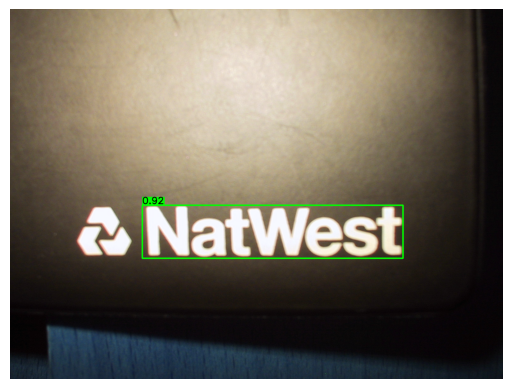

{'name': 'text', 'class': 0, 'confidence': 0.95674, 'box': {'x1': 758.60236, 'y1': 364.49411, 'x2': 895.69952, 'y2': 439.9563}}


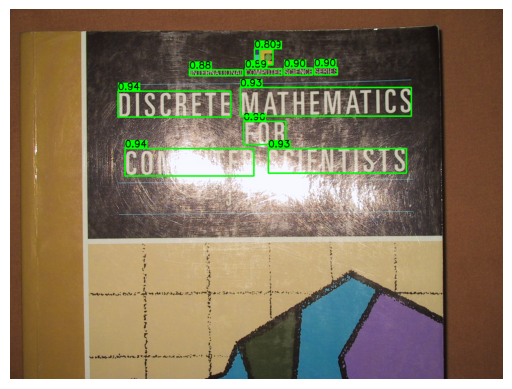

{'name': 'text', 'class': 0, 'confidence': 0.94944, 'box': {'x1': 881.87854, 'y1': 431.69131, 'x2': 1204.12756, 'y2': 501.97729}}


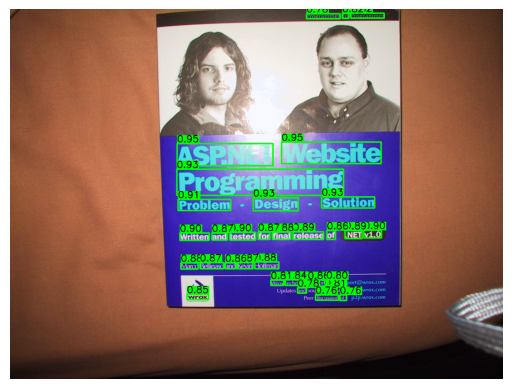

{'name': 'text', 'class': 0, 'confidence': 0.94642, 'box': {'x1': 787.62244, 'y1': 338.59085, 'x2': 1089.91736, 'y2': 413.59421}}


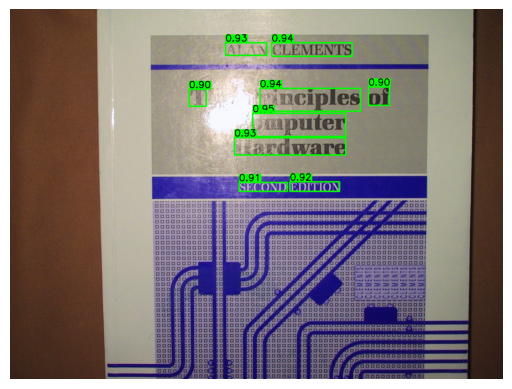

{'name': 'text', 'class': 0, 'confidence': 0.95283, 'box': {'x1': 795.03534, 'y1': 368.68149, 'x2': 932.77966, 'y2': 453.04703}}


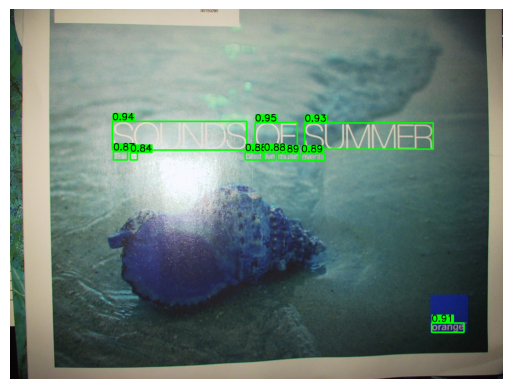

{'name': 'text', 'class': 0, 'confidence': 0.95307, 'box': {'x1': 1040.13562, 'y1': 887.33069, 'x2': 1178.47522, 'y2': 972.6062}}


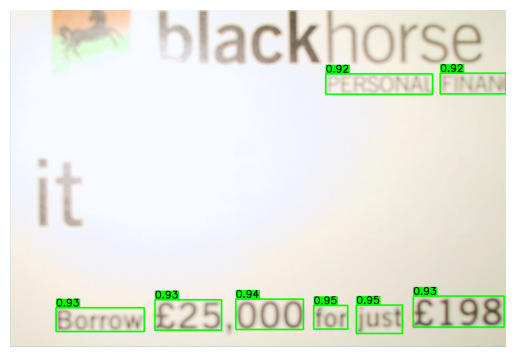

{'name': 'text', 'class': 0, 'confidence': 0.947, 'box': {'x1': 790.63464, 'y1': 367.69858, 'x2': 1055.98499, 'y2': 439.84195}}


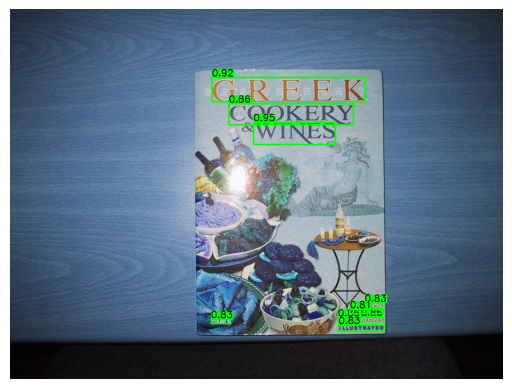

{'name': 'text', 'class': 0, 'confidence': 0.93323, 'box': {'x1': 385.3194, 'y1': 279.32684, 'x2': 1500.44824, 'y2': 495.68213}}


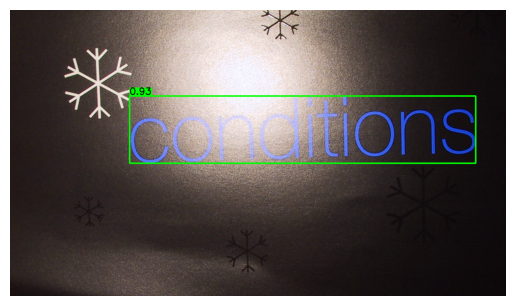

{'name': 'text', 'class': 0, 'confidence': 0.9446, 'box': {'x1': 579.75751, 'y1': 333.83975, 'x2': 1222.2019, 'y2': 434.82547}}


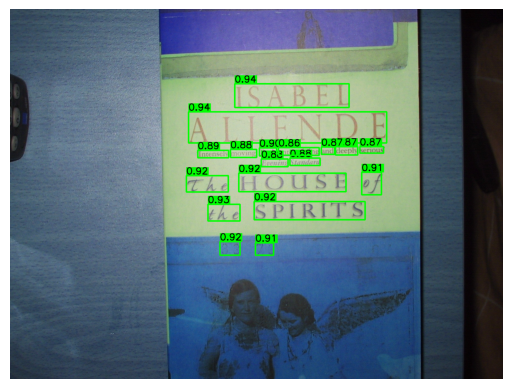

{'name': 'text', 'class': 0, 'confidence': 0.93359, 'box': {'x1': 730.12555, 'y1': 289.01886, 'x2': 1008.21735, 'y2': 349.06058}}


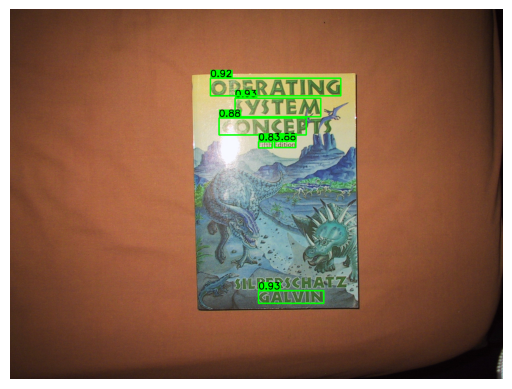

In [29]:
inference (model_path='./best.pt', image_paths= images_test_model[:10])

{'name': 'text', 'class': 0, 'confidence': 0.93986, 'box': {'x1': 37.57453, 'y1': 218.82462, 'x2': 198.28075, 'y2': 270.08429}}


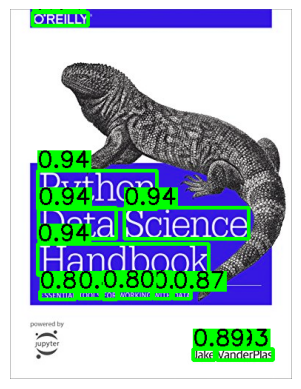

{'name': 'text', 'class': 0, 'confidence': 0.95267, 'box': {'x1': 34.98889, 'y1': 374.89377, 'x2': 263.8107, 'y2': 454.52112}}


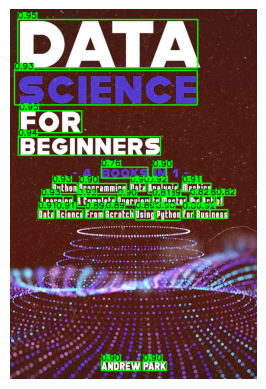

{'name': 'text', 'class': 0, 'confidence': 0.92694, 'box': {'x1': 464.78833, 'y1': 432.79526, 'x2': 628.84521, 'y2': 486.08826}}


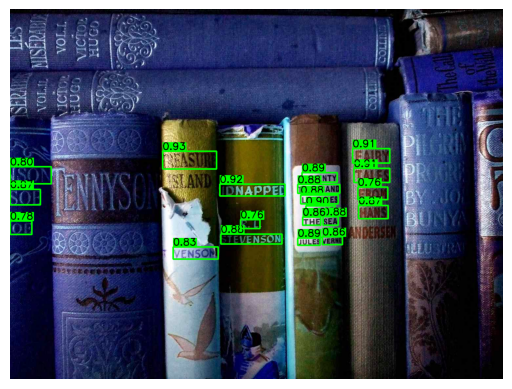

{'name': 'text', 'class': 0, 'confidence': 0.94056, 'box': {'x1': 411.41498, 'y1': 130.62515, 'x2': 593.80713, 'y2': 160.92227}}


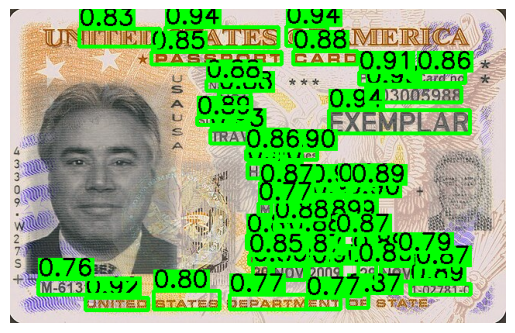

In [30]:
test_new = ['/content/92270temp.jpeg', '/content/E9XYSgVo7y_beNGQtTR6EbK1ge7RbHZmRAaAc2yZU5HvfzryHCt1uSUfm6DBT5yCRosMFTI86p_Y99yQQLOekbN8iPRA3gmgnEZHB0erqleNtyI4w9bhrCkFgFjOghX1oEnnxeHD.jpeg', '/content/3587804365_fa15d9f0e7_o-5c39394fc9e77c0001570010.jpeg', '/content/Passport_card.jpeg']
inference (model_path='./best.pt', image_paths= test_new)

# III. Text Recognition

In [1]:
def plot_image_with_bbs(img_path, bbs, labels):
    """
    Trực quan hóa bounding box với label lên ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        bbs (list): Danh sách các bounding box.
        labels (list): Danh sách các label.
    """
    # Đọc ảnh
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Duyệt qua từng bounding box
    for idx, bb in enumerate(bbs):
        # Vẽ bounding box lên ảnh
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        # Vẽ label lên cạnh bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        line_type = 2
        text_thickness = 2
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)


        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)


        cv2.putText(
            img,
            label,
            (int(bb[0]), int(bb[1] - 10)),
            font,
            font_scale,
            font_color,
            text_thickness,
            line_type
        )

    # Show ảnh
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Random chỉ mục của một ảnh bất kỳ để visualize
i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])

NameError: name 'random' is not defined

## 1. Design CRNN architecture